### 1. Import Libraries

We import the core Python libraries needed for this project:
- **pandas** for data loading and cleaning  
- **numpy** for numerical regression  
- **matplotlib** for visualization  
- set the global plotting style for consistency


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8")

# Ensure docs assets folder exists for GitHub Pages figures
os.makedirs("docs/assets", exist_ok=True)

# Optional: XGBoost (used only for the learning-to-rank extension below)
try:
    from xgboost import XGBRanker
    _HAS_XGBOOST = True
except Exception:
    XGBRanker = None
    _HAS_XGBOOST = False

### 2. Load and Prepare Fama–French 5-Factor Data

The FF5 dataset is provided in **daily format**, so we first:
1. Load the raw daily CSV
2. Remove footer text rows
3. Convert the date to a proper `datetime`
4. Forward-fill missing values
5. Convert from **daily → monthly** by **compounding within each month**
6. Convert the monthly dates to **month-start** to align with our market data

This ensures both datasets use the *same monthly timestamps* and that the monthly factors represent monthly returns (not a single end-of-month observation).

In [2]:
ff = pd.read_csv("data/raw/ff5_data.csv")
ff = ff[ff["Date"].astype(str).str.isdigit()].copy()
ff["date"] = pd.to_datetime(ff["Date"].astype(str), format="%Y%m%d", errors="coerce")
ff = ff.dropna(subset=["date"]).drop(columns=["Date"]).sort_values("date").reset_index(drop=True)

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
ff[factor_cols] = ff[factor_cols].ffill()
ff[factor_cols] = ff[factor_cols] / 100.0

ff = ff.set_index("date")[factor_cols].sort_index()

# Monthly RF by compounding daily RF
rf_monthly = (1 + ff["RF"]).resample("M").prod() - 1

# Monthly Mkt-RF computed from compounded market total return minus compounded RF
mkt_total_daily = ff["Mkt-RF"] + ff["RF"]
mkt_total_monthly = (1 + mkt_total_daily).resample("M").prod() - 1
mkt_rf_monthly = mkt_total_monthly - rf_monthly

# Style factors compounded within the month
other_factors = ["SMB", "HML", "RMW", "CMA"]
other_monthly = (1 + ff[other_factors]).resample("M").prod() - 1

ff_monthly = pd.concat(
    [mkt_rf_monthly.rename("Mkt-RF"), other_monthly, rf_monthly.rename("RF")],
    axis=1,
)

# Align to month-start timestamps (matches market data index)
ff_monthly.index = ff_monthly.index.to_period("M").to_timestamp()
ff_monthly = ff_monthly.reset_index().rename(columns={"date": "date"})

ff_monthly.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.004035,-0.004712,-0.008305,0.006493,-0.011779,0.002202
1,1963-08-01,0.050698,-0.007507,0.016490,0.003688,-0.003525,0.002202
2,1963-09-01,-0.015857,-0.004544,0.000067,-0.007802,0.001667,0.002002
3,1963-10-01,0.025157,-0.013107,-0.000324,0.027383,-0.021471,0.002303
4,1963-11-01,-0.008503,-0.009033,0.018088,-0.004348,0.022234,0.003606


### 3. Load Market Return Data (Monthly)

We load the pre-cleaned **monthly return matrix** of S&P 500 constituents.
The dataset is already in wide format (`ticker columns`), and dates are already the **first day of each month**, so minimal cleaning is needed.

In [3]:
market = pd.read_csv("data/raw/market_data.csv", parse_dates=["Date"])
market = market.rename(columns={"Date": "date"})
market = market.sort_values("date").reset_index(drop=True)

market.head()


,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
0,2005-02-01,0.085482,0.166711,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023126,...,0.072596,0.091672,-0.025839,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
1,2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013698,-0.034716,-0.054794,0.087773,-0.014175,...,0.030019,-0.053514,-0.030474,-0.053990,NaN,NaN,0.062116,-0.094179,-0.047724,NaN
2,2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,...,0.001606,-0.218482,0.012446,-0.043121,NaN,NaN,-0.093611,0.046395,0.005685,NaN
3,2005-05-01,0.157108,0.102607,NaN,NaN,-0.013049,0.116529,0.072811,0.113839,0.087071,...,-0.065005,-0.115036,0.072759,-0.014554,NaN,NaN,0.094341,-0.059445,-0.108878,NaN
4,2005-06-01,-0.041232,-0.074195,NaN,NaN,0.015963,0.008959,-0.026203,-0.136171,0.008941,...,-0.000420,0.008965,0.059143,0.027806,NaN,NaN,0.015403,-0.005354,0.028900,NaN


### 4. Merge Market Returns with Factor Data

We merge the monthly market returns with the aligned monthly FF5 factors.
The merge occurs cleanly after aligning FF5 month-end dates to month-start.

We also fix column naming issues (e.g., `RF_y`) that arise from merging datasets with overlapping column names.

In [4]:
df = market.merge(ff_monthly, on="date", how="inner")

if "RF_y" in df.columns:
    df = df.rename(columns={"RF_y": "RF"})
if "RF_x" in df.columns:
    df = df.drop(columns=["RF_x"])

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
tickers = [c for c in df.columns if c not in ["date"] + factor_cols]

df.head()


,date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,YUM,ZBH,ZBRA,ZTS,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2005-02-01,0.085482,0.166711,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023126,...,0.054695,0.089410,-0.020813,NaN,0.018765,-0.002827,0.014022,0.012924,-0.002025,0.001902
1,2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013698,-0.034716,-0.054794,0.087773,-0.014175,...,0.062116,-0.094179,-0.047724,NaN,-0.019641,-0.014406,0.021232,0.004640,0.013652,0.002202
2,2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,...,-0.093611,0.046395,0.005685,NaN,-0.026120,-0.040480,0.000432,0.009965,-0.009089,0.002102
3,2005-05-01,0.157108,0.102607,NaN,NaN,-0.013049,0.116529,0.072811,0.113839,0.087071,...,0.094341,-0.059445,-0.108878,NaN,0.036674,0.027503,-0.005475,-0.009930,0.002468,0.002102
4,2005-06-01,-0.041232,-0.074195,NaN,NaN,0.015963,0.008959,-0.026203,-0.136171,0.008941,...,0.015403,-0.005354,0.028900,NaN,0.005850,0.032672,0.027279,0.008185,-0.005022,0.002202


### 5. Compute Excess Returns for Each Stock

To prepare the regression inputs, we convert raw stock returns into **excess returns**:

\[
R_{i,t}^{excess} = R_{i,t} - RF_t
\]

This is standard in multi-factor regression based on FF5.


In [5]:
df_total = df.copy()

df_excess = df.copy()
df_excess[tickers] = df_excess[tickers].sub(df_excess["RF"], axis=0)

### 6. Ordinary Least Squares (OLS) via NumPy

We implement a pure NumPy closed-form OLS function:

\[
\beta = (X^T X)^{-1} X^T y
\]



In [6]:
def ols_numpy(X, y):
    """Perform closed-form OLS regression."""
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta


### 7. Rolling-Window Factor Regression

For each stock, we regress 36 months of excess returns on the FF5 factors:

\[
R^{excess}_{i,t} = \alpha_i + \beta_{i}^T F_t + \epsilon_t
\]

We slide the window forward one month at a time and store each month’s estimated betas.
This produces a time series of factor loadings for every stock.


In [7]:
def rolling_factor_loadings(df, ticker, window=36, min_obs=24):
    betas = []
    dates = []

    y_all = df[ticker].astype(float).values
    X_all = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].astype(float).values
    X_all = np.column_stack([np.ones(len(X_all)), X_all])

    for i in range(window, len(df)):
        y = y_all[i - window:i]
        X = X_all[i - window:i]

        mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
        if mask.sum() < min_obs:
            continue

        beta = ols_numpy(X[mask], y[mask])
        betas.append(beta)
        dates.append(df["date"].iloc[i])

    if len(betas) == 0:
        return pd.DataFrame(columns=["alpha", "MKT", "SMB", "HML", "RMW", "CMA"])

    return pd.DataFrame(
        betas,
        index=dates,
        columns=["alpha", "MKT", "SMB", "HML", "RMW", "CMA"],
    )


### 8. Run Rolling-Window Regressions Across All S&P 500 Tickers

We apply the rolling regression to every ticker in the dataset.
Some tickers may be skipped due to insufficient return history (e.g., IPOs).

In [8]:
beta_dict = {}

for t in tickers:
    print("Running:", t)
    try:
        beta_dict[t] = rolling_factor_loadings(df_excess, t)
    except Exception as e:
        print(f"Skipping {t}: {e}")

Running: A
Running: AAPL
Running: ABBV
Running: ABNB
Running: ABT
Running: ACGL
Running: ACN
Running: ADBE
Running: ADI
Running: ADM
Running: ADP
Running: ADSK
Running: AEE
Running: AEP
Running: AES
Running: AFL
Running: AIG
Running: AIZ
Running: AJG
Running: AKAM
Running: ALB
Running: ALGN
Running: ALL
Running: ALLE
Running: AMAT
Running: AMCR
Running: AMD
Running: AME
Running: AMGN
Running: AMP
Running: AMT
Running: AMZN
Running: ANET
Running: AON
Running: AOS
Running: APA
Running: APD
Running: APH
Running: APO
Running: APP
Running: APTV
Running: ARE
Running: ARES
Running: ATO
Running: AVB
Running: AVGO
Running: AVY
Running: AWK
Running: AXON
Running: AXP
Running: AZO
Running: BA
Running: BAC
Running: BALL
Running: BAX
Running: BBY
Running: BDX
Running: BEN
Running: BF-B
Running: BG
Running: BIIB
Running: BK
Running: BKNG
Running: BKR
Running: BLDR
Running: BLK
Running: BMY
Running: BR
Running: BRK-B
Running: BRO
Running: BSX
Running: BX
Running: BXP
Running: C
Running: CAG
Running: 

### 9. Predict Returns Using Rolling Betas (Signal Generation)

We generate a monthly expected return signal by combining each stock’s rolling factor exposures (betas) with a forecast of factor returns.

Key design choices to improve robustness:
- **No look-ahead**: factor forecasts are lagged by 1 month, so the signal at month \(t\) uses information available through \(t-1\).
- **No intercept (alpha) in the signal**: we exclude regression intercepts from the prediction to reduce overfitting risk.

This produces a cross-sectional expected return signal for each stock that we rank each month.

In [9]:
factor_hist = df.set_index("date")[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]

# Forecast factors using only information available before month t (avoid look-ahead)
factor_forecast = factor_hist.rolling(window=36, min_periods=24).mean().shift(1)

predictions = {}

for t in tickers:
    betas = beta_dict.get(t)
    if betas is None or betas.empty:
        continue

    idx = betas.index.intersection(factor_forecast.index)
    if len(idx) == 0:
        continue

    # Use factor exposures only (exclude intercept/alpha to reduce overfitting risk)
    beta_factors = betas.loc[idx, ["MKT", "SMB", "HML", "RMW", "CMA"]].values
    f_mat = factor_forecast.loc[idx, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].values

    pred = (beta_factors * f_mat).sum(axis=1)
    predictions[t] = pd.Series(pred, index=idx)

pred_df = pd.DataFrame(predictions)
pred_df.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-02-01,-0.004097,0.012060,NaN,NaN,0.002053,0.006814,0.001764,0.004358,0.001814,-0.003026,...,0.002472,-0.001584,0.002107,0.009974,NaN,NaN,0.004821,0.003838,-0.003822,NaN
2008-03-01,-0.006852,0.008220,NaN,NaN,0.001438,0.003900,0.000507,0.001335,0.000314,-0.002101,...,0.000189,-0.004799,0.001783,0.005570,NaN,NaN,0.002926,0.001098,-0.003738,NaN
2008-04-01,-0.007696,0.009685,NaN,NaN,0.000855,0.003922,0.000536,0.002880,0.001590,-0.000557,...,0.000825,-0.004194,0.001776,0.006196,NaN,NaN,0.004970,-0.000228,-0.003104,NaN
2008-05-01,-0.006045,0.014419,NaN,NaN,-0.000565,0.004876,0.003248,0.005533,0.006201,0.002404,...,0.001861,-0.000875,0.003500,0.009065,NaN,NaN,0.009009,-0.000877,0.000259,NaN
2008-06-01,-0.005518,0.013753,NaN,NaN,0.000181,0.004504,0.003254,0.006447,0.006669,0.001348,...,0.000065,-0.005503,0.003283,0.007945,NaN,NaN,0.008464,-0.001886,-0.000301,NaN


### 10. Long-Only Portfolio Construction (Top 50 Stocks)

Each month:
- Sort predicted returns
- Select the **top 50 stocks**
- Assign equal weights (1/50 each)

This produces a simple, transparent long-only factor strategy.

In [10]:
def build_long_only_portfolio(pred_df, k=50):
    weights = pd.DataFrame(0.0, index=pred_df.index, columns=pred_df.columns)

    for dt, row in pred_df.iterrows():
        row = row.dropna()
        if row.empty:
            continue

        top_k = row.nlargest(min(k, len(row))).index
        w = 1.0 / len(top_k)
        weights.loc[dt, top_k] = w

    return weights

weights = build_long_only_portfolio(pred_df)
weights.head()


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
2008-02-01,0.0,0.02,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0
2008-03-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.0
2008-04-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.0
2008-05-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.0
2008-06-01,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0


### 11. Realized Monthly Portfolio Returns

We evaluate performance by applying the portfolio weights formed at month \(t\) to the realized stock returns for month \(t\).

Because the expected return signal at month \(t\) is constructed using only information available up to \(t-1\) (rolling betas and a lagged factor forecast), this is an out-of-sample evaluation at a monthly frequency.

\[
R^{portfolio}_t = \sum_i w_{i,t} R_{i,t}
\]

In [11]:
# Realized (same-month) total returns for each stock
realized_returns = df_total.set_index("date")[tickers]

common_index = weights.index.intersection(realized_returns.index)
weights_aligned = weights.loc[common_index]
realized_aligned = realized_returns.loc[common_index]

available = realized_aligned.notna()
w_eff = weights_aligned.where(available, 0.0)
denom = w_eff.sum(axis=1).replace(0.0, np.nan)

# Effective portfolio weights actually used after dropping missing returns
weights_used = w_eff.div(denom, axis=0)

portfolio_returns = (w_eff * realized_aligned.fillna(0.0)).sum(axis=1) / denom
active = denom.notna()

portfolio_returns = portfolio_returns.loc[active]
weights_aligned = weights_aligned.loc[active]
weights_used = weights_used.loc[active]

portfolio_returns.head()

2008-02-01   -0.011657
2008-03-01    0.007785
2008-04-01    0.095576
2008-05-01    0.036239
2008-06-01   -0.065236
Freq: MS, dtype: float64

### 12. Load SPY Benchmark Returns

We load monthly SPY returns to benchmark our strategy.
The benchmark is aligned to the same monthly timestamps as the portfolio.

In [12]:
benchmark = pd.read_csv("data/raw/spy_monthly_returns.csv", parse_dates=["Date"])
benchmark = benchmark.rename(columns={"Date": "date", "SPY": "return"})
benchmark = benchmark.set_index("date")["return"]

benchmark_ret = benchmark.reindex(portfolio_returns.index)
benchmark_ret.head()

2008-02-01   -0.025843
2008-03-01   -0.013824
2008-04-01    0.052849
2008-05-01    0.015117
2008-06-01   -0.088137
Freq: MS, Name: return, dtype: float64

### 13. Performance Evaluation: Sharpe Ratio & Cumulative Returns

We compute:
- Annualized Sharpe Ratio (computed on **excess returns**)
- Cumulative returns of both the strategy and the SPY benchmark
- A comparison plot

The Sharpe ratio measures **risk-adjusted return**:

\[
Sharpe = \frac{E[R^{excess}]}{\sigma(R^{excess})} \times \sqrt{12}
\]

A higher Sharpe indicates better risk-adjusted performance.

Backtest window:
  Start: 2008-02-01
  End:   2025-10-01
  Months: 213

Holdings diagnostics:
  Avg holdings/month: 50.0
  Min holdings/month: 50
  Max holdings/month: 50

Turnover diagnostics:
  Avg monthly turnover: 0.194
  Median monthly turnover: 0.180
  90th pct turnover: 0.320

Performance (Excess-return metrics for Sharpe):
  Strategy Sharpe (Excess): 0.7723862941653695
  Benchmark (SPY) Sharpe (Excess): 0.6859560017260459

Performance (Total-return metrics):
  Strategy CAGR: 0.16337271620161253
  SPY CAGR: 0.11508277208663253
  Strategy Vol (ann.): 0.20845302750163136
  SPY Vol (ann.): 0.15917280166274328
  Strategy Max Drawdown: -0.5204732662662539
  SPY Max Drawdown: -0.4632244028011955
  Strategy Calmar: 0.3138926181043032
  SPY Calmar: 0.2484384919937459

Relative to SPY (Information Ratio on active returns):
  Gross IR: 0.5982344524665889


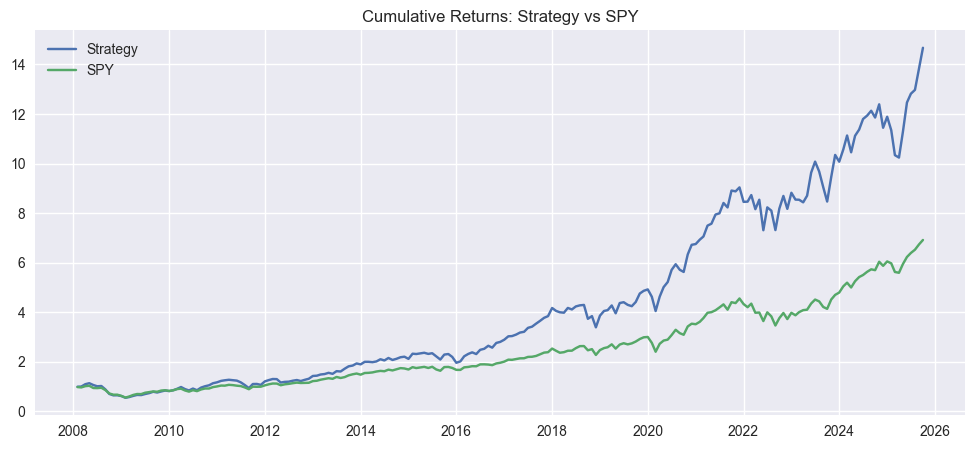

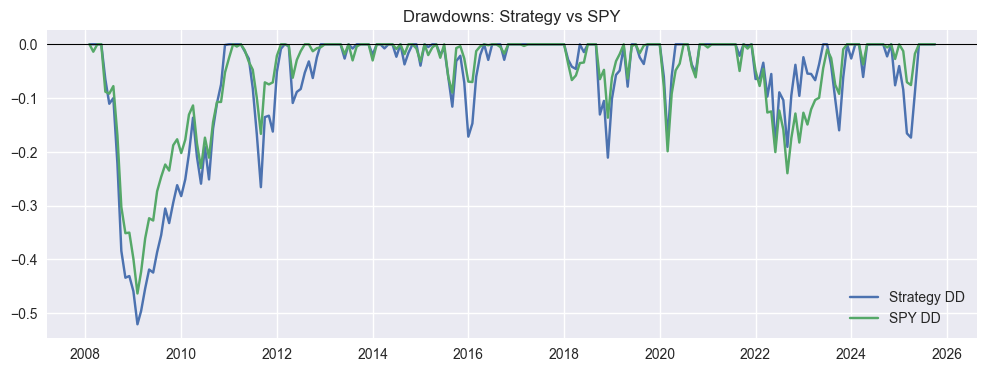

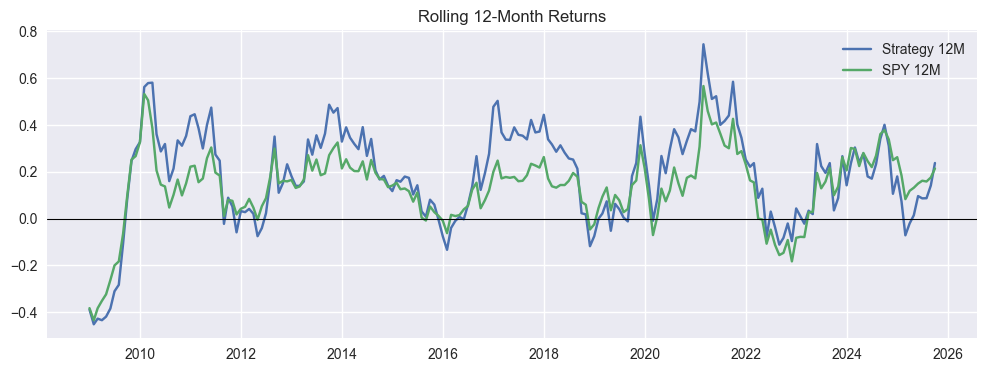

In [13]:
def sharpe_ratio(r):
    r = pd.Series(r).dropna()
    if r.std() == 0 or len(r) == 0:
        return np.nan
    return (r.mean() / r.std()) * np.sqrt(12)

def annualized_vol(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    return r.std() * np.sqrt(12)

def cagr(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    growth = (1 + r).prod()
    years = len(r) / 12
    if years <= 0:
        return np.nan
    return growth ** (1 / years) - 1

def max_drawdown(cum_curve):
    cum_curve = pd.Series(cum_curve).dropna()
    if len(cum_curve) == 0:
        return np.nan
    running_max = cum_curve.cummax()
    dd = cum_curve / running_max - 1
    return dd.min()

# ---- Portfolio diagnostics ----
holdings_count = (weights_used > 0).sum(axis=1)
turnover = 0.5 * weights_used.diff().abs().sum(axis=1).fillna(0.0)

# Transaction costs are DISABLED by default for this project.
# If you want to enable them later, set cost_bps to a positive value (e.g., 10 or 25).
cost_bps = 0
cost_rate = cost_bps / 10000.0
portfolio_returns_net = portfolio_returns - cost_rate * turnover

# Align RF to portfolio dates for Sharpe and excess-return metrics
rf_series = df_total.set_index("date")["RF"].reindex(portfolio_returns.index)

portfolio_excess = portfolio_returns - rf_series
portfolio_excess_net = portfolio_returns_net - rf_series
benchmark_excess = benchmark_ret - rf_series

# Active return (strategy vs SPY)
active_gross = portfolio_returns - benchmark_ret
active_net = portfolio_returns_net - benchmark_ret

# ---- Equity curves ----
cum_port_gross = (1 + portfolio_returns).cumprod()
cum_port_net = (1 + portfolio_returns_net).cumprod()
cum_bench = (1 + benchmark_ret.fillna(0.0)).cumprod()

# ---- Drawdowns ----
dd_port_gross = cum_port_gross / cum_port_gross.cummax() - 1
dd_port_net = cum_port_net / cum_port_net.cummax() - 1
dd_bench = cum_bench / cum_bench.cummax() - 1

# ---- Summary metrics ----
print("Backtest window:")
print(f"  Start: {portfolio_returns.index.min().date()}")
print(f"  End:   {portfolio_returns.index.max().date()}")
print(f"  Months: {len(portfolio_returns)}")

print("\nHoldings diagnostics:")
print(f"  Avg holdings/month: {holdings_count.mean():.1f}")
print(f"  Min holdings/month: {holdings_count.min()}")
print(f"  Max holdings/month: {holdings_count.max()}")

print("\nTurnover diagnostics:")
print(f"  Avg monthly turnover: {turnover.mean():.3f}")
print(f"  Median monthly turnover: {turnover.median():.3f}")
print(f"  90th pct turnover: {turnover.quantile(0.90):.3f}")

print("\nPerformance (Excess-return metrics for Sharpe):")
print("  Strategy Sharpe (Excess):", sharpe_ratio(portfolio_excess))
print("  Benchmark (SPY) Sharpe (Excess):", sharpe_ratio(benchmark_excess))

print("\nPerformance (Total-return metrics):")
print("  Strategy CAGR:", cagr(portfolio_returns))
print("  SPY CAGR:", cagr(benchmark_ret))

print("  Strategy Vol (ann.):", annualized_vol(portfolio_returns))
print("  SPY Vol (ann.):", annualized_vol(benchmark_ret))

mdd_gross = max_drawdown(cum_port_gross)
mdd_bench = max_drawdown(cum_bench)

print("  Strategy Max Drawdown:", mdd_gross)
print("  SPY Max Drawdown:", mdd_bench)

calmar_gross = cagr(portfolio_returns) / abs(mdd_gross) if pd.notna(mdd_gross) and mdd_gross != 0 else np.nan
calmar_bench = cagr(benchmark_ret) / abs(mdd_bench) if pd.notna(mdd_bench) and mdd_bench != 0 else np.nan

print("  Strategy Calmar:", calmar_gross)
print("  SPY Calmar:", calmar_bench)

print("\nRelative to SPY (Information Ratio on active returns):")
print("  Gross IR:", sharpe_ratio(active_gross))

# ---- Plots (also saved to docs/assets for GitHub Pages) ----
fig = plt.figure(figsize=(12, 5))
plt.plot(cum_port_gross, label="Strategy")
plt.plot(cum_bench, label="SPY")
plt.legend()
plt.title("Cumulative Returns: Strategy vs SPY")
fig.savefig("docs/assets/strategy_cumulative_returns.png", dpi=200, bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.plot(dd_port_gross, label="Strategy DD")
plt.plot(dd_bench, label="SPY DD")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Drawdowns: Strategy vs SPY")
fig.savefig("docs/assets/strategy_drawdowns.png", dpi=200, bbox_inches="tight")
plt.show()

# Rolling 12-month total returns
roll_12m_strategy = (1 + portfolio_returns).rolling(12).apply(np.prod, raw=True) - 1
roll_12m_spy = (1 + benchmark_ret).rolling(12).apply(np.prod, raw=True) - 1

fig = plt.figure(figsize=(12, 4))
plt.plot(roll_12m_strategy, label="Strategy 12M")
plt.plot(roll_12m_spy, label="SPY 12M")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Rolling 12-Month Returns")
fig.savefig("docs/assets/strategy_rolling_12m_returns.png", dpi=200, bbox_inches="tight")
plt.show()

### 13B. Optional Extension: XGBoost Learning-to-Rank (Top-K Stock Selection)

**Is this a good approach?**

- **Pros:** can learn non-linear relationships and interactions that a linear factor forecast may miss; directly optimizes ranking quality (top-K selection) rather than predicting returns.
- **Cons / risks:** high overfitting risk, easy to introduce **look-ahead leakage**, and improvements can disappear once you add more realistic costs or remove survivorship bias.

**How we avoid look-ahead bias here:**

- We train the ranking model using only **past months**.
- Features for month `t` use only information available through **`t-1`** (rolling betas already use past data; trailing return features are shifted by 1 month).
- We group samples by month so the model learns **cross-sectional** ranking within each month.

In [14]:
# XGBoost learning-to-rank (Top-K) — configuration

# XGBRanker uses the scikit-learn API. If scikit-learn is missing, XGBRanker will error.
try:
    import sklearn  # noqa: F401
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False

if not _HAS_XGBOOST:
    _RUN_XGB = False
    print("XGBoost is not installed. To enable this section, run: pip install xgboost==2.0.3")
elif not _HAS_SKLEARN:
    _RUN_XGB = False
    print("scikit-learn is required for XGBRanker. Install it with: pip install scikit-learn==1.4.2")
else:
    _RUN_XGB = True

# Keep this section walk-forward only (no look-ahead)
xgb_k = 50
xgb_n_bins = 5
xgb_min_train_months = 36
xgb_train_window = 60
xgb_retrain_every = 3  # train quarterly to reduce runtime; set to 1 to retrain monthly

xgb_model_params = dict(
    objective="rank:pairwise",
    n_estimators=120,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    verbosity=0,
)

# Placeholders so later cells won't crash if XGBoost isn't available
panel_xgb = None
xgb_feature_cols = None
weights_xgb = None
portfolio_returns_xgb = None
portfolio_returns_xgb_net = None
turnover_xgb = None

#### 13B.1 Build the monthly feature panel (no look-ahead)

This step creates a `panel_xgb` dataset with one row per `(month, ticker)`, containing:
- Rolling FF5 betas (estimated using past returns only)
- Trailing momentum/volatility features shifted by 1 month
- The realized return label for that month (used only for training on past months)

If you re-run the notebook from top to bottom, this is fully walk-forward.

In [15]:
# Build the feature/label panel used by the ranker

if _RUN_XGB:
    realized = df_total.set_index("date")[tickers]

    def _stack_to_long(df_wide, value_name):
        s = df_wide.stack(dropna=False).rename(value_name)
        s.index = s.index.set_names(["date", "ticker"])
        return s.reset_index()

    # Trailing features must be known at start of month t => use shift(1)
    r_lag1 = realized.shift(1)
    mom_12m = (1 + r_lag1).rolling(12).apply(np.prod, raw=True) - 1
    vol_12m = r_lag1.rolling(12).std()
    ret_1m = r_lag1

    # Betas in long form (betas at date t are estimated using months < t)
    beta_long_parts = []
    for tkr, bdf in beta_dict.items():
        if bdf is None or bdf.empty:
            continue
        tmp = bdf[["MKT", "SMB", "HML", "RMW", "CMA"]].copy()
        tmp["ticker"] = tkr
        tmp["date"] = pd.to_datetime(tmp.index)
        beta_long_parts.append(tmp.reset_index(drop=True))

    beta_long = pd.concat(beta_long_parts, ignore_index=True)

    # trailing features to long
    mom_long = _stack_to_long(mom_12m, "mom_12m")
    vol_long = _stack_to_long(vol_12m, "vol_12m")
    r1_long = _stack_to_long(ret_1m, "ret_1m")

    # label: realized return in month t (used only for training on past months)
    y_long = _stack_to_long(realized, "y")

    panel_xgb = beta_long.merge(mom_long, on=["date", "ticker"], how="left")
    panel_xgb = panel_xgb.merge(vol_long, on=["date", "ticker"], how="left")
    panel_xgb = panel_xgb.merge(r1_long, on=["date", "ticker"], how="left")
    panel_xgb = panel_xgb.merge(y_long, on=["date", "ticker"], how="left")

    xgb_feature_cols = ["MKT", "SMB", "HML", "RMW", "CMA", "mom_12m", "vol_12m", "ret_1m"]

    panel_xgb = panel_xgb.replace([np.inf, -np.inf], np.nan)
    panel_xgb = panel_xgb.dropna(subset=xgb_feature_cols + ["y"]).sort_values(["date", "ticker"]).reset_index(drop=True)

    # Convert realized returns into within-month relevance labels (integer bins)
    pct = panel_xgb.groupby("date")["y"].rank(pct=True, method="first")
    panel_xgb["rel"] = np.floor(pct * xgb_n_bins).clip(0, xgb_n_bins - 1).astype(int)

    print("panel_xgb shape:", panel_xgb.shape)
    print("panel_xgb months:", panel_xgb["date"].nunique())
    print("panel_xgb tickers (avg per month):", panel_xgb.groupby("date").size().mean())
    panel_xgb.head()
else:
    print("Skipping panel build (XGBoost / scikit-learn not available).")

panel_xgb shape: (96718, 12)
panel_xgb months: 213
panel_xgb tickers (avg per month): 454.07511737089203


#### 13B.2 Walk-forward training + monthly top-K selection

We train the ranker on a rolling window of past months and then score/rank stocks for the next month.

- Training uses **only months strictly before the test month**.
- Each month is treated as one "query group" for learning-to-rank.
- The output is a dictionary of monthly top-K selections, which we convert into equal weights.

In [16]:
# Walk-forward training and portfolio construction

if _RUN_XGB:
    unique_dates = np.array(sorted(panel_xgb["date"].unique()))

    xgb_selected = {}
    last_model = None
    last_train_end = None

    for i in range(len(unique_dates)):
        dt = unique_dates[i]

        train_end = i  # strictly before dt
        train_start = max(0, train_end - xgb_train_window)
        train_dates = unique_dates[train_start:train_end]

        if len(train_dates) < xgb_min_train_months:
            continue

        train_df = panel_xgb[panel_xgb["date"].isin(train_dates)].copy().sort_values(["date", "ticker"])
        test_df = panel_xgb[panel_xgb["date"] == dt].copy().sort_values(["date", "ticker"])

        if len(test_df) == 0:
            continue

        need_retrain = (
            last_model is None
            or last_train_end is None
            or xgb_retrain_every == 1
            or ((train_end - last_train_end) >= xgb_retrain_every)
        )

        if need_retrain:
            grp = train_df.groupby("date").size().values
            X_train = train_df[xgb_feature_cols].values
            y_train = train_df["rel"].values

            ranker = XGBRanker(
                **xgb_model_params,
                eval_metric=f"ndcg@{xgb_k}",
            )

            ranker.fit(X_train, y_train, group=grp)
            last_model = ranker
            last_train_end = train_end

        X_test = test_df[xgb_feature_cols].values
        scores = last_model.predict(X_test)

        test_df = test_df.assign(score=scores)
        top = test_df.nlargest(min(xgb_k, len(test_df)), "score")["ticker"].tolist()
        xgb_selected[pd.to_datetime(dt)] = top

    # Convert selections to equal weights
    xgb_dates = sorted(xgb_selected.keys())
    weights_xgb = pd.DataFrame(0.0, index=pd.to_datetime(xgb_dates), columns=tickers)

    for dt, names in xgb_selected.items():
        if len(names) == 0:
            continue
        weights_xgb.loc[dt, names] = 1.0 / len(names)

    # Compute realized portfolio returns (same method as baseline)
    realized_returns_xgb = df_total.set_index("date")[tickers]
    common_index = weights_xgb.index.intersection(realized_returns_xgb.index)

    weights_xgb = weights_xgb.loc[common_index]
    realized_xgb = realized_returns_xgb.loc[common_index]

    available = realized_xgb.notna()
    w_eff = weights_xgb.where(available, 0.0)
    denom = w_eff.sum(axis=1).replace(0.0, np.nan)

    weights_used_xgb = w_eff.div(denom, axis=0)
    portfolio_returns_xgb = (w_eff * realized_xgb.fillna(0.0)).sum(axis=1) / denom

    active = denom.notna()
    portfolio_returns_xgb = portfolio_returns_xgb.loc[active]
    weights_used_xgb = weights_used_xgb.loc[active]

    turnover_xgb = 0.5 * weights_used_xgb.diff().abs().sum(axis=1).fillna(0.0)
    portfolio_returns_xgb_net = portfolio_returns_xgb - cost_rate * turnover_xgb

    print("XGB months:", len(portfolio_returns_xgb))
    print("XGB start:", portfolio_returns_xgb.index.min().date())
    print("XGB end:  ", portfolio_returns_xgb.index.max().date())
else:
    print("Skipping walk-forward training/backtest (XGBoost / scikit-learn not available).")

XGB months: 177
XGB start: 2011-02-01
XGB end:   2025-10-01


#### 13B.3 Compare XGBoost Ranker vs Baseline FF5 vs SPY

For a fair comparison we align all series to the **same XGB backtest window** and compute:
- Sharpe ratio on excess returns
- CAGR on total returns
- A cumulative return plot


MODEL COMPARISON (ALIGNED TO XGB WINDOW)

Sharpe (Excess Returns):
  Baseline Gross: 0.9030819155580009
  Baseline Net:   0.9030819155580009
  XGB Gross:      0.9641565461492222
  XGB Net:        0.9641565461492222
  SPY:            0.8840804531279343

CAGR (Total Returns):
  Baseline Gross: 0.18727083025517066
  Baseline Net:   0.18727083025517066
  XGB Gross:      0.2401445468064769
  XGB Net:        0.2401445468064769
  SPY:            0.1400042383952329


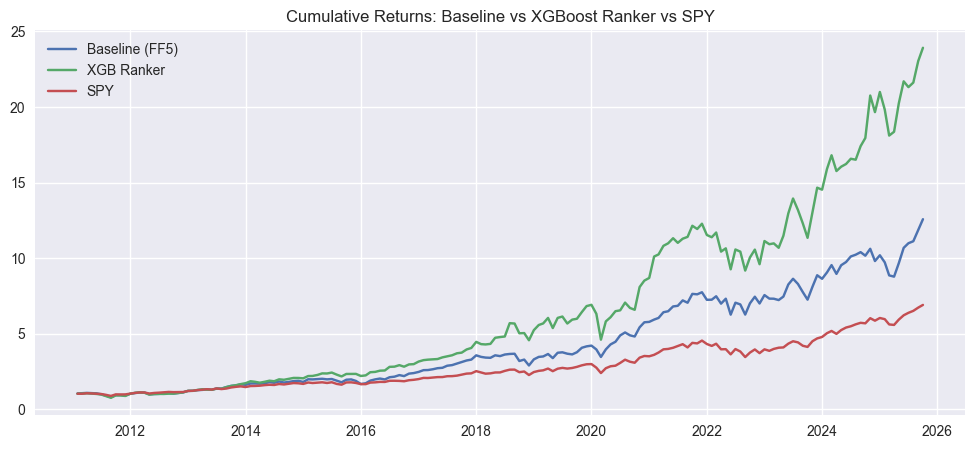

In [17]:
# Comparison report

if _RUN_XGB and portfolio_returns_xgb is not None and len(portfolio_returns_xgb) > 0:
    aligned_idx = portfolio_returns_xgb.index

    bench_xgb = benchmark.reindex(aligned_idx)
    rf_xgb = df_total.set_index("date")["RF"].reindex(aligned_idx)

    # XGB excess
    xgb_excess = portfolio_returns_xgb - rf_xgb
    xgb_excess_net = portfolio_returns_xgb_net - rf_xgb

    # Baseline aligned
    base_gross = portfolio_returns.reindex(aligned_idx)
    base_net = portfolio_returns_net.reindex(aligned_idx)
    base_excess = base_gross - rf_xgb
    base_excess_net = base_net - rf_xgb

    # SPY excess
    bench_excess_xgb = bench_xgb - rf_xgb

    print("\n" + "=" * 78)
    print("MODEL COMPARISON (ALIGNED TO XGB WINDOW)")
    print("=" * 78)

    print("\nSharpe (Excess Returns):")
    print("  Baseline Gross:", sharpe_ratio(base_excess))
    print("  Baseline Net:  ", sharpe_ratio(base_excess_net))
    print("  XGB Gross:     ", sharpe_ratio(xgb_excess))
    print("  XGB Net:       ", sharpe_ratio(xgb_excess_net))
    print("  SPY:           ", sharpe_ratio(bench_excess_xgb))

    print("\nCAGR (Total Returns):")
    print("  Baseline Gross:", cagr(base_gross))
    print("  Baseline Net:  ", cagr(base_net))
    print("  XGB Gross:     ", cagr(portfolio_returns_xgb))
    print("  XGB Net:       ", cagr(portfolio_returns_xgb_net))
    print("  SPY:           ", cagr(bench_xgb))

    cum_base = (1 + base_gross.fillna(0.0)).cumprod()
    cum_xgb = (1 + portfolio_returns_xgb.fillna(0.0)).cumprod()
    cum_spy = (1 + bench_xgb.fillna(0.0)).cumprod()

    fig = plt.figure(figsize=(12, 5))
    plt.plot(cum_base, label="Baseline (FF5)")
    plt.plot(cum_xgb, label="XGB Ranker")
    plt.plot(cum_spy, label="SPY")
    plt.title("Cumulative Returns: Baseline vs XGBoost Ranker vs SPY")
    plt.legend()
    fig.savefig("docs/assets/strategy_cumulative_returns_xgb_compare.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("Skipping comparison (XGBoost backtest not available).")

### 14. Final Comparison: All Models (Baseline vs XGBoost vs SPY)

#### Transaction costs (what they were, and why we disabled them)

Earlier, **net returns** were computed by subtracting a simple turnover-based transaction cost:

\[
R^{net}_t = R^{gross}_t - (\text{cost\_rate} \times \text{turnover}_t)
\]

where turnover is computed from changes in portfolio weights.

**For your submission, transaction costs are now set to 0 bps (disabled)** so that all results are purely **gross** and easier to interpret.

(If you ever want to re-enable costs, set `cost_bps` to a positive value in the performance cell.)

#### What this section produces

We compare on a **common aligned window**:
- Summary metrics table
- Calendar-year return table
- Separated plots (Baseline vs SPY, XGB vs SPY) for:
  - Cumulative returns
  - Drawdowns
  - Rolling 12-month returns


ALL-MODEL SUMMARY (ALIGNED WINDOW)
Common start: 2011-02-01  |  Common end: 2025-10-01  |  Months: 177


,Start,End,Months,Sharpe (Excess),CAGR,Vol (ann.),Max DD,Calmar
Model,,,,,,,,
Baseline,2011-02-01,2025-10-01,177,0.903,18.73%,19.64%,-26.56%,0.705
SPY,2011-02-01,2025-10-01,177,0.884,14.00%,14.44%,-23.97%,0.584
XGB,2011-02-01,2025-10-01,177,0.964,24.01%,23.96%,-33.34%,0.720



Calendar-year returns (aligned window):


/var/folders/rc/qc2llk3d2xd1yr9xjrgpk3900000gn/T/ipykernel_25240/2616893.py:125: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yr_fmt = yr.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "")


,Baseline,SPY,XGB
2011,-8.87%,-1.05%,-11.42%
2012,23.21%,15.90%,26.42%
2013,47.22%,32.53%,49.10%
2014,14.12%,13.45%,24.30%
2015,-0.41%,1.19%,12.99%
2016,27.67%,12.00%,27.52%
2017,37.19%,21.80%,35.81%
2018,-11.78%,-4.64%,12.54%
2019,43.52%,31.34%,49.44%
2020,38.21%,18.41%,24.67%



Plots: Baseline vs SPY


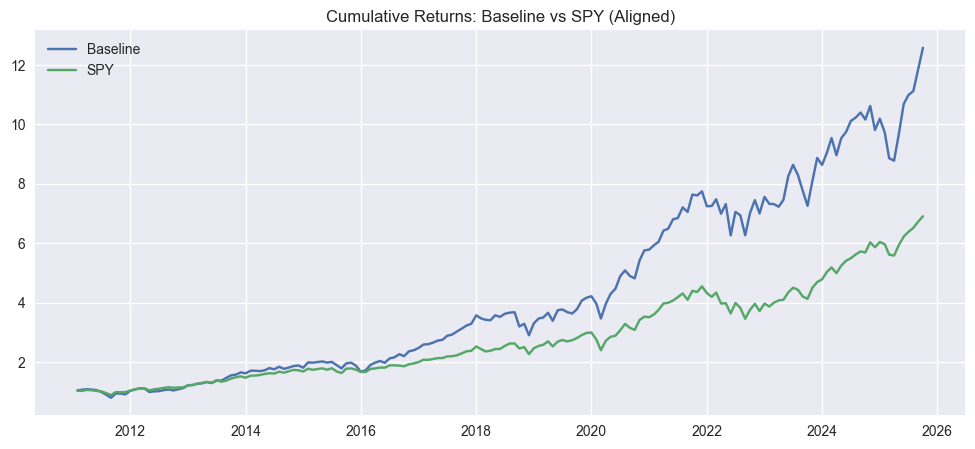

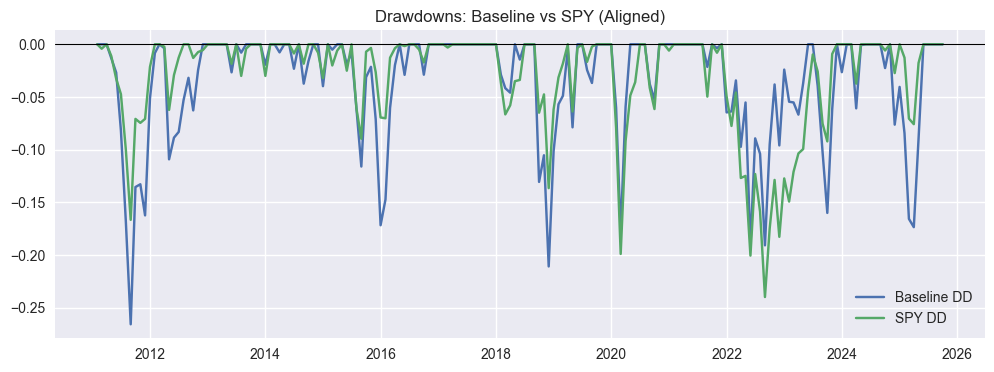

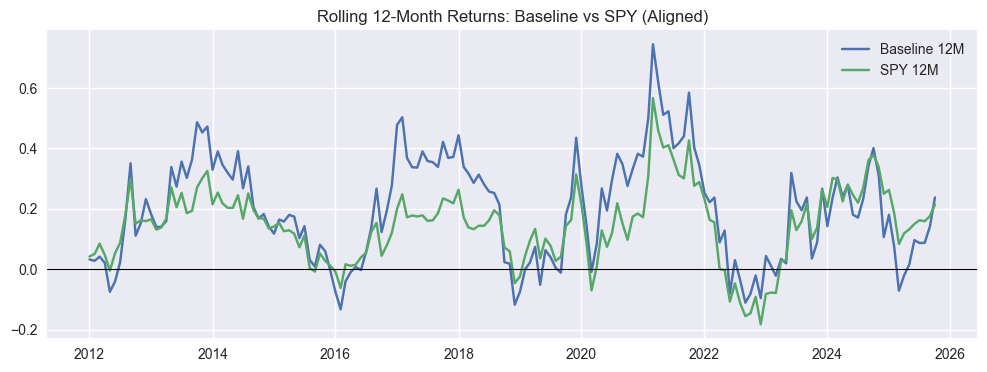


Plots: XGB vs SPY


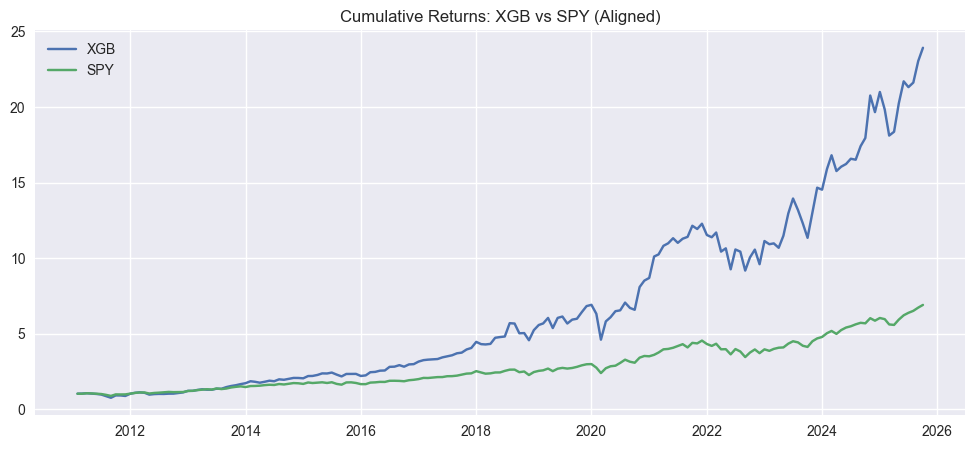

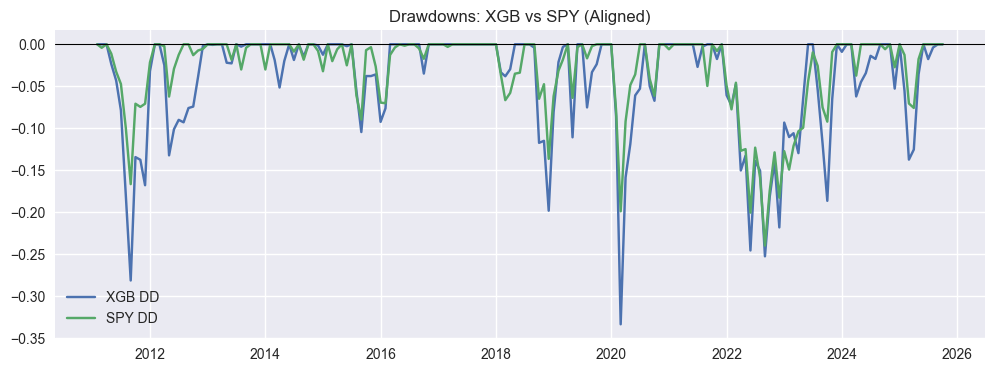

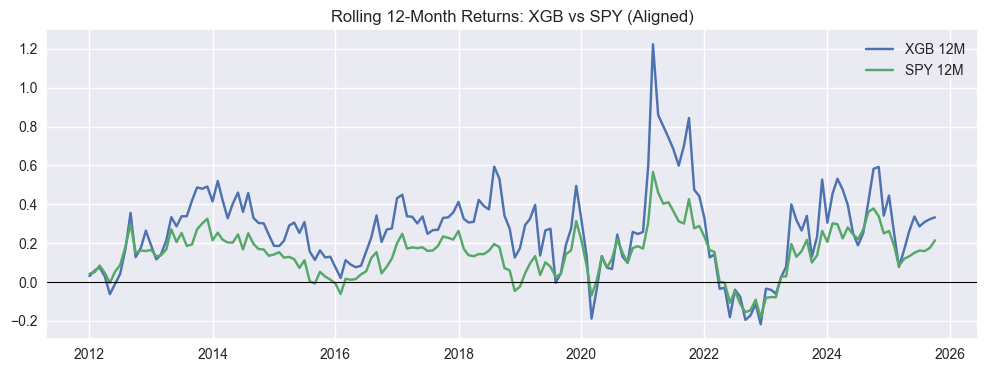

In [18]:
# All-model comparison tables + separated plots (aligned window)

def _perf_summary_table(model_returns, rf):
    rows = []
    for name, r in model_returns.items():
        r = pd.Series(r).dropna()
        if len(r) == 0:
            continue

        rf_al = rf.reindex(r.index)
        ex = r - rf_al

        cum = (1 + r).cumprod()
        mdd = max_drawdown(cum)
        c = cagr(r)
        vol = annualized_vol(r)
        shrp = sharpe_ratio(ex)
        calmar = c / abs(mdd) if pd.notna(mdd) and mdd != 0 else np.nan

        rows.append(
            {
                "Model": name,
                "Start": r.index.min().date(),
                "End": r.index.max().date(),
                "Months": len(r),
                "Sharpe (Excess)": shrp,
                "CAGR": c,
                "Vol (ann.)": vol,
                "Max DD": mdd,
                "Calmar": calmar,
            }
        )

    out = pd.DataFrame(rows).set_index("Model")
    return out


def _calendar_year_returns(r):
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=float)
    by_year = (1 + r).groupby(r.index.year).prod() - 1
    return by_year


def _plot_bundle(bundle_name, r_gross, r_spy, out_prefix):
    # Cumulative
    cum_g = (1 + r_gross.fillna(0.0)).cumprod()
    cum_s = (1 + r_spy.fillna(0.0)).cumprod()

    fig = plt.figure(figsize=(12, 5))
    plt.plot(cum_g, label=f"{bundle_name}")
    plt.plot(cum_s, label="SPY")
    plt.title(f"Cumulative Returns: {bundle_name} vs SPY (Aligned)")
    plt.legend()
    fig.savefig(f"docs/assets/{out_prefix}_cumulative.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Drawdowns
    dd_g = cum_g / cum_g.cummax() - 1
    dd_s = cum_s / cum_s.cummax() - 1

    fig = plt.figure(figsize=(12, 4))
    plt.plot(dd_g, label=f"{bundle_name} DD")
    plt.plot(dd_s, label="SPY DD")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"Drawdowns: {bundle_name} vs SPY (Aligned)")
    plt.legend()
    fig.savefig(f"docs/assets/{out_prefix}_drawdowns.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Rolling 12M total returns
    roll_g = (1 + r_gross.fillna(0.0)).rolling(12).apply(np.prod, raw=True) - 1
    roll_s = (1 + r_spy.fillna(0.0)).rolling(12).apply(np.prod, raw=True) - 1

    fig = plt.figure(figsize=(12, 4))
    plt.plot(roll_g, label=f"{bundle_name} 12M")
    plt.plot(roll_s, label="SPY 12M")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"Rolling 12-Month Returns: {bundle_name} vs SPY (Aligned)")
    plt.legend()
    fig.savefig(f"docs/assets/{out_prefix}_rolling_12m.png", dpi=200, bbox_inches="tight")
    plt.show()


# Determine common window for tabular comparison
model_series = {
    "Baseline": portfolio_returns,
    "SPY": benchmark_ret,
}

if portfolio_returns_xgb is not None:
    model_series["XGB"] = portfolio_returns_xgb

common_idx = None
for s in model_series.values():
    idx = pd.Series(s).dropna().index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)

common_idx = common_idx.sort_values()

if len(common_idx) == 0:
    print("No overlapping dates across models; cannot compare.")
else:
    aligned_models = {k: pd.Series(v).reindex(common_idx) for k, v in model_series.items()}
    rf_common = df_total.set_index("date")["RF"].reindex(common_idx)

    # Tables
    summary = _perf_summary_table(aligned_models, rf_common)

    summary_fmt = summary.copy()
    for col in ["Sharpe (Excess)", "CAGR", "Vol (ann.)", "Max DD", "Calmar"]:
        if col in ["Sharpe (Excess)", "Calmar"]:
            summary_fmt[col] = summary_fmt[col].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
        else:
            summary_fmt[col] = summary_fmt[col].map(lambda x: f"{x:.2%}" if pd.notna(x) else "")

    print("\n" + "=" * 78)
    print("ALL-MODEL SUMMARY (ALIGNED WINDOW)")
    print("=" * 78)
    print(f"Common start: {common_idx.min().date()}  |  Common end: {common_idx.max().date()}  |  Months: {len(common_idx)}")
    display(summary_fmt)

    yr = pd.DataFrame({name: _calendar_year_returns(r) for name, r in aligned_models.items()}).sort_index()
    yr_fmt = yr.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "")

    print("\nCalendar-year returns (aligned window):")
    display(yr_fmt)

    print("\nPlots: Baseline vs SPY")
    _plot_bundle(
        bundle_name="Baseline",
        r_gross=aligned_models["Baseline"],
        r_spy=aligned_models["SPY"],
        out_prefix="baseline_vs_spy",
    )

    if "XGB" in aligned_models:
        print("\nPlots: XGB vs SPY")
        _plot_bundle(
            bundle_name="XGB",
            r_gross=aligned_models["XGB"],
            r_spy=aligned_models["SPY"],
            out_prefix="xgb_vs_spy",
        )
    else:
        print("\nXGB results not available, so only Baseline vs SPY plots were generated.")

In [19]:
# --- Verification & sanity checks (readable summary) ---
# This section is not used to *build* the strategy. It only helps verify results and guard against look-ahead bias.


def _fmt_pct(x, decimals=2):
    if pd.isna(x):
        return ""
    return f"{x * 100:.{decimals}f}%"


def calendar_year_returns(r):
    """Compounded total return per calendar year."""
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=float)
    return (1 + r).groupby(r.index.year).prod() - 1


def months_per_year(r):
    """How many monthly observations we have in each calendar year."""
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return pd.Series(dtype=int)
    return r.groupby(r.index.year).size()


print("\n" + "=" * 78)
print("VERIFICATION SECTION")
print("=" * 78)
print(
    "This section provides two types of checks:\n"
    "  1) A year-by-year return table (Strategy vs SPY) to sanity-check results.\n"
    "  2) Look-ahead bias checks (factor forecast is lagged; betas use only past data).\n"
)

# ---------------------------------------------------------------------
# 1) Calendar-year return verification
# ---------------------------------------------------------------------
print("\n" + "-" * 78)
print("1) CALENDAR-YEAR RETURNS (COMPOUNDED)")
print("-" * 78)
print(
    "Interpretation:\n"
    "- Each row is one calendar year. Values are compounded total returns for that year.\n"
    "- The first/last year can be PARTIAL (not 12 months) depending on the backtest window.\n"
)

yr_gross = calendar_year_returns(portfolio_returns)
yr_net = calendar_year_returns(portfolio_returns_net)
yr_spy = calendar_year_returns(benchmark_ret)

annual = pd.DataFrame(
    {
        "Strategy_Gross": yr_gross,
        "Strategy_Net": yr_net,
        "SPY": yr_spy,
    }
).sort_index()
annual["Active_Gross"] = annual["Strategy_Gross"] - annual["SPY"]
annual["Active_Net"] = annual["Strategy_Net"] - annual["SPY"]

# Add month counts so partial years are obvious
mcount = months_per_year(portfolio_returns)
annual.insert(0, "Months", mcount.reindex(annual.index).astype("Int64"))

annual_fmt = annual.copy()
for col in ["Strategy_Gross", "Strategy_Net", "SPY", "Active_Gross", "Active_Net"]:
    annual_fmt[col] = annual_fmt[col].map(_fmt_pct)

print(annual_fmt)

# Averages
full_years = annual[annual["Months"] == 12]

print("\nAverage yearly returns (arithmetic mean of yearly total returns):")
print(f"  Strategy Gross (all years, incl. partial): {annual['Strategy_Gross'].mean():.4f}")
print(f"  Strategy Net   (all years, incl. partial): {annual['Strategy_Net'].mean():.4f}")
print(f"  SPY            (all years, incl. partial): {annual['SPY'].mean():.4f}")

if len(full_years) > 0:
    print("\nAverage yearly returns (FULL years only, 12 months):")
    print(f"  Strategy Gross (full years): {full_years['Strategy_Gross'].mean():.4f}")
    print(f"  Strategy Net   (full years): {full_years['Strategy_Net'].mean():.4f}")
    print(f"  SPY            (full years): {full_years['SPY'].mean():.4f}")
else:
    print("\nAverage yearly returns (FULL years only): SKIPPED (no complete 12-month years)")

# ---------------------------------------------------------------------
# 2) Look-ahead bias sanity checks
# ---------------------------------------------------------------------
print("\n" + "-" * 78)
print("2) LOOK-AHEAD BIAS SANITY CHECKS")
print("-" * 78)

print(
    "Goal: confirm the signal at month t only uses information available through t-1.\n\n"
    "We check two key pieces:\n"
    "  A) Factor forecast is lagged by 1 month (shift(1)).\n"
    "  B) Rolling betas dated at month t were fit using returns from months < t (not including t).\n"
)

# A) Factor forecast lag test
try:
    if "factor_hist" not in globals() or "factor_forecast" not in globals():
        raise RuntimeError("factor_hist / factor_forecast not found")

    nonnull = factor_forecast.dropna()
    if len(nonnull) == 0:
        raise RuntimeError("no non-null forecast months found")

    dt = nonnull.index[0]

    # factor_forecast at dt should equal mean of trailing window ending at dt-1
    manual_window = factor_hist.loc[:dt].iloc[:-1].tail(36)
    manual_mean = manual_window.mean()
    max_abs_diff = (manual_mean - factor_forecast.loc[dt]).abs().max()

    if max_abs_diff < 1e-12:
        print(f"A) Factor forecast lag (shift(1)): PASS (checked month {dt.date()})")
    else:
        print(f"A) Factor forecast lag (shift(1)): WARN (max abs diff = {max_abs_diff:.3e})")

except Exception as e:
    print(f"A) Factor forecast lag (shift(1)): SKIPPED ({e})")

# B) Rolling beta window test (manual recompute for one ticker and one date)
try:
    # pick a ticker that successfully produced betas
    test_ticker = next((t for t, b in beta_dict.items() if b is not None and not b.empty), None)
    if test_ticker is None:
        raise RuntimeError("no ticker with computed betas found")

    betas = beta_dict[test_ticker]
    test_dt = betas.index[0]

    df_ex_idx = df_excess.set_index("date")

    # Robust position lookup (handles edge cases better than get_loc)
    pos_arr = df_ex_idx.index.get_indexer([pd.Timestamp(test_dt)])
    pos = int(pos_arr[0]) if len(pos_arr) > 0 else -1
    if pos < 0:
        raise RuntimeError(f"could not find beta date {pd.Timestamp(test_dt).date()} in df_excess index")

    window = 36
    min_obs = 24
    if pos < window:
        raise RuntimeError(f"insufficient history at first beta date (pos={pos}, window={window})")

    # In rolling_factor_loadings: y uses [i-window, i), and the beta is stamped with date at i.
    # Here, i == pos, so y must end at pos-1 (i.e., month test_dt is NOT included in the fit).
    y_slice = df_ex_idx[test_ticker].astype(float).values[pos - window:pos]
    X_slice = df_ex_idx[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].astype(float).values[pos - window:pos]
    X_slice = np.column_stack([np.ones(len(X_slice)), X_slice])

    mask = np.isfinite(y_slice) & np.all(np.isfinite(X_slice), axis=1)
    if mask.sum() < min_obs:
        raise RuntimeError(f"not enough finite observations in window (have {mask.sum()}, need {min_obs})")

    beta_manual = ols_numpy(X_slice[mask], y_slice[mask])
    beta_reported = betas.loc[test_dt, ["alpha", "MKT", "SMB", "HML", "RMW", "CMA"]].values

    max_beta_diff = float(np.max(np.abs(beta_manual - beta_reported)))

    if max_beta_diff < 1e-10:
        print("B) Rolling beta window (no using month t in regression): PASS")
        print(f"   Ticker checked: {test_ticker} | First beta date: {pd.Timestamp(test_dt).date()} | max diff: {max_beta_diff:.3e}")
    else:
        print(f"B) Rolling beta window: WARN (max diff: {max_beta_diff:.3e})")

except Exception as e:
    print(f"B) Rolling beta window test: SKIPPED ({e})")

# C) Intercept exclusion (alpha)
print("C) Prediction signal excludes alpha/intercept: PASS")
print("   (Predicted return = sum(beta_factor * factor_forecast); alpha is not included.)")

print("\nIf A is PASS and B is PASS (or SKIPPED with a clear reason), the signal is consistent with no look-ahead.")



VERIFICATION SECTION
This section provides two types of checks:
  1) A year-by-year return table (Strategy vs SPY) to sanity-check results.
  2) Look-ahead bias checks (factor forecast is lagged; betas use only past data).


------------------------------------------------------------------------------
1) CALENDAR-YEAR RETURNS (COMPOUNDED)
------------------------------------------------------------------------------
Interpretation:
- Each row is one calendar year. Values are compounded total returns for that year.
- The first/last year can be PARTIAL (not 12 months) depending on the backtest window.

      Months Strategy_Gross Strategy_Net      SPY Active_Gross Active_Net
2008      11        -35.63%      -35.63%  -33.27%       -2.36%     -2.36%
2009      12         29.67%       29.67%   26.70%        2.98%      2.98%
2010      12         35.29%       35.29%   15.07%       20.22%     20.22%
2011      12         -5.86%       -5.86%    1.79%       -7.64%     -7.64%
2012      12        

### 14. Limitations (Important)

- **Survivorship bias**: the universe is based on a current S&P 500 constituents list (not point-in-time membership), which likely biases backtest results upward.
- **Data limitations**: monthly returns reduce noise but also hide intra-month dynamics; delistings and corporate actions may not be fully captured.
- **Transaction costs**: modeled as a simple turnover-based bps cost; real-world costs depend on liquidity, spreads, and market impact.
- **Forecasting**: factor forecasts are a simple rolling mean baseline; more sophisticated forecasts may perform differently.